# Wide and Deep Model

<br>

A linear model with a wide set of crossed-column (co-occurrence) features can memorize the feature interactions, while deep neural networks (DNN) can generalize the feature patterns through low-dimensional dense embeddings learned for the sparse features. [**Wide-and-deep**](https://arxiv.org/abs/1606.07792) learning jointly trains wide linear model and deep neural networks to combine the benefits of memorization and generalization for recommender systems.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append("../../")
import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
#import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from reco_utils.common.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    SEED
)
from reco_utils.common import tf_utils, gpu_utils, plot
from reco_utils.dataset import movielens
from reco_utils.dataset.pandas_df_utils import user_item_pairs
from reco_utils.dataset.python_splitters import python_random_split
import reco_utils.evaluation.python_evaluation as evaluator
import reco_utils.recommender.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.version)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: <module 'tensorflow._api.v2.version' from '/opt/conda/envs/reco_base/lib/python3.6/site-packages/tensorflow/_api/v2/version/__init__.py'>
GPUs:
 [{'device_name': 'GeForce RTX 2080 Ti', 'total_memory': 5509.0, 'free_memory': 5055.990234375}]


In [5]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 15

# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]

# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True
# Item feature column name
ITEM_FEAT_COL = 'subject'

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = './outputs/model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [6]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

### 1. Prepare Data

#### 1.1 *subject* as item feature

In [42]:
econ = pd.read_csv('~/work/Capstone/registrar-recommender/00_data/2013-2020/econ.csv')
# create index for class year
class_year_dic = {1:'first year fall term', 2: 'first year spring term', 
                  3:'second year fall term', 4: 'second year spring term',
                  5: 'third year fall term', 6: 'third year spring term',
                  7: 'fourth year fall term', 8: 'fourth year spring term'}
yr_to_idx = {v:k for k, v in class_year_dic.items()}
term_dic = {0: 'First', 2:'Second', 4:'Third', 6:'Fourth'}

def preprocess(data):
    '''
    Preprocess the raw data input and return the dataframe in standardized format and user/item dictionaries obtained from it
    '''
    # columns of interest
    cols = ['Calculation ID', 'Subject', 'Catalog', 'Descr', 'Number Grade', 'Major 1', 'Minor 1', 'Minor 2', 'Class Year']
    df = data[cols]
    df.columns = [str.lower(col.replace(' ', '_')) for col in df.columns]

    # lowercase string cols to use
    for col in df.columns:
        if isinstance(df.loc[0, col], str):
            df[col] = df[col].str.lower() 

    # exclude summer terms which is na in class_year
    df = df[df['class_year'].notna()]
    # map class year to corresponding index number
    df['class_year'] = df['class_year'].map(yr_to_idx)


    # create index for courses (item dic)
    idx_course = {idx: descr for idx, descr in enumerate(df['descr'].unique())} 
    # map course descriptions to indices
    course_idx = {v:k for k,v in idx_course.items()}
    df['course_idx'] = df['descr'].map(course_idx)
    df = df.drop(['descr'], axis=1)

    # create index for students (user dic)
    # map str(calculation_id)_to_idx
    user_to_idx = {str(calc_id): idx for idx, calc_id in enumerate(df['calculation_id'].unique())}

    ## normalize grade for each student
    #df['grade_normed'] = df['number_grade'] / df.groupby('calculation_id')['number_grade'].transform('sum')

    # make calc_id string type
    df['calculation_id'] = df['calculation_id'].astype(str)
    return df, idx_course, user_to_idx

df, idx_course, user_dic = preprocess(econ)
print('number of students=', len(user_dic))
print('number of classes=', len(idx_course))
print()

df.head()

number of students= 1467
number of classes= 2191



/opt/conda/envs/reco_base/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


calculation_id  subject catalog  number_grade         major_1 minor_1  \
0     15839.4125  italian     335           3.7  economics (bs)     NaN   
1     15839.4125  italian     390           4.0  economics (bs)     NaN   
2     15839.4125  italian     333           4.0  economics (bs)     NaN   
3     15839.4125  italian     301           4.0  economics (bs)     NaN   
4     15839.4125  italian    490s           4.0  economics (bs)     NaN   

  minor_2  class_year  course_idx  
0     NaN         1.0           0  
1     NaN         1.0           1  
2     NaN         2.0           2  
3     NaN         3.0           3  
4     NaN         3.0           4

Now this is a matrix of grades for every student in each row and every course in each column.

Now, we normalize by each COURSE's mean

In [44]:
# average grade for each course
avg_gpa_per_crs = (df.groupby('course_idx')['number_grade'].apply(sum)/df.groupby('course_idx')['calculation_id'].apply(set).apply(len)).to_frame().reset_index()
avg_gpa_per_crs.columns = ['course_idx', 'avg_grade']
df2 = pd.merge(df, avg_gpa_per_crs, on='course_idx', how='left')
df2['grade_normed'] = df2['number_grade']/df2['avg_grade']
df2

calculation_id  subject catalog  number_grade         major_1 minor_1  \
0         15839.4125  italian     335           3.7  economics (bs)     NaN   
1         15839.4125  italian     390           4.0  economics (bs)     NaN   
2         15839.4125  italian     333           4.0  economics (bs)     NaN   
3         15839.4125  italian     301           4.0  economics (bs)     NaN   
4         15839.4125  italian    490s           4.0  economics (bs)     NaN   
...              ...      ...     ...           ...             ...     ...   
33942        31205.5     econ    337s           4.0  economics (bs)     NaN   
33943        31205.5  compsci     216           4.0  economics (bs)     NaN   
33944        31205.5     chem   101dl           4.0  economics (bs)     NaN   
33945        31205.5      psy     104           4.0  economics (bs)     NaN   
33946        31205.5     econ     378           4.0  economics (bs)     NaN   

      minor_2  class_year  course_idx  avg_grade  grade_normed  
0         NaN         1.0           0   3.800000      0.973684  
1         NaN         1.0           1   4.666667      0.857143  
2         NaN         2.0           2   4.000000      1.000000  
3         NaN         3.0           3   4.000000      1.000000  
4         NaN         3.0           4   4.000000      1.000000  
...       ...         ...         ...        ...           ...  
33942     NaN         2.0        1862   3.714286      1.076923  
33943     NaN         2.0        1205   3.909836      1.023061  
33944     NaN         4.0         891   3.076190      1.300310  
33945     NaN         1.0         110   3.730120      1.072351  
33946     NaN         4.0           8   3.837500      1.042345  

[33947 rows x 11 columns]

In [45]:
data = df2[['calculation_id', 'course_idx', 'grade_normed', 'subject', 'class_year']]
data.head()

calculation_id  course_idx  grade_normed  subject  class_year
0     15839.4125           0      0.973684  italian         1.0
1     15839.4125           1      0.857143  italian         1.0
2     15839.4125           2      1.000000  italian         2.0
3     15839.4125           3      1.000000  italian         3.0
4     15839.4125           4      1.000000  italian         3.0

#### 1.2 Encode Item Feature
To use subject from the model, we multi-hot-encode them with scikit-learn's [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html).

In [46]:
use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)

if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'subject' into int array (multi-hot representation) to use as item features
    subject_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = subject_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("subject:", subject_encoder.classes_)
    display(data.head())

subject: ['aaas' 'aerosci' 'ames' 'ami' 'arabic' 'arthist' 'arts&sci' 'artsvis'
 'ba' 'biochem' 'biology' 'bme' 'canadian' 'ccs' 'cee' 'cellbio' 'chem'
 'childpol' 'chinese' 'clst' 'compsci' 'creole' 'culanth' 'dance' 'decsci'
 'docst' 'ece' 'econ' 'educ' 'egr' 'egrmgmt' 'ehd' 'energy' 'english'
 'environ' 'eos' 'ethics' 'evanth' 'fintech' 'french' 'genome' 'german'
 'glhlth' 'greek' 'gsf' 'hebrew' 'hindi' 'history' 'humandev' 'i&e' 'ics'
 'immunol' 'inch_bus' 'inch_phl' 'inch_pln' 'inch_swa' 'incs_hea'
 'inyu_ami' 'inyu_hst' 'isis' 'iss' 'italian' 'iusc_ctp' 'jewishst' 'jpn'
 'korean' 'latamer' 'latin' 'law' 'linguist' 'lit' 'lsgs' 'math' 'medren'
 'mgm' 'mms' 'music' 'navalsci' 'neurobio' 'neurosci' 'pathol' 'persian'
 'pharm' 'phil' 'physedu' 'physics' 'pjms' 'polish' 'polsci' 'portugue'
 'psy' 'pubpol' 'religion' 'robt_aad' 'robt_bio' 'robt_bus' 'robt_com'
 'robt_cps' 'robt_dra' 'robt_eco' 'robt_edu' 'robt_eng' 'robt_epd'
 'robt_ess' 'robt_fre' 'robt_geg' 'robt_grm' 'robt_hst' 'rob

/opt/conda/envs/reco_base/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


calculation_id  course_idx  grade_normed  \
0     15839.4125           0      0.973684   
1     15839.4125           1      0.857143   
2     15839.4125           2      1.000000   
3     15839.4125           3      1.000000   
4     15839.4125           4      1.000000   

                                             subject  class_year  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1.0  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1.0  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         2.0  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         3.0  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         3.0

#### 1.3 Train and Test Split

In [47]:
user_preset = True

num_students = data['calculation_id'].nunique()
split = round(num_students * .80)

train_students = data['calculation_id'].unique()[0:split]
test_students = data['calculation_id'].unique()[split:]

print('total number of students:',num_students)
print('number of train students:',len(train_students))
print('number of test students:',len(test_students))

train = data[data['calculation_id'].isin(train_students)]
test = data[data['calculation_id'].isin(test_students)]

# further split into year1/2 and year3/4
test_34 = test[test['class_year'] >= 5]
test_12 = test[test['class_year'] <= 4]
train = train.append(test_12)

total number of students: 1467
number of train students: 1174
number of test students: 293


In [78]:
# if not use_preset:
#     train, test = python_random_split(data, ratio=0.8, seed=RANDOM_SEED)
# else:
#     train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))
#     test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
#     data = pd.concat([train, test])

# print("{} train samples and {} test samples".format(len(train), len(test)))

In [48]:
# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 2191 items and 1467 users in the dataset


### 2. Build Model

Wide-and-deep model consists of a linear model and DNN. We use the following hyperparameters and feature sets for the model:

<br> | <div align="center">Wide (linear) model</div> | <div align="center">Deep neural networks</div>
---|---|---
Feature set | <ul><li>User-item co-occurrence features<br>to capture how their co-occurrence<br>correlates with the target rating</li></ul> | <ul><li>Deep, lower-dimensional embedding vectors<br>for every user and item</li><li>Item feature vector</li></ul>
Hyperparameters | <ul><li>FTRL optimizer</li><li>Learning rate = 0.0029</li><li>L1 regularization = 0.0</li></ul> | <ul><li>Adagrad optimizer</li><li>Learning rate = 0.1</li><li>Hidden units = [128, 256, 32]</li><li>Dropout rate = 0.4</li><li>Use batch normalization (Batch size = 64)</li><li>User embedding vector size = 4</li><li>Item embedding vector size = 4</li></ul>

<br>

* [FTRL optimizer](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* [Adagrad optimizer](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

Note, the hyperparameters are optimized for the training set. We used **Azure Machine Learning service** ([AzureML](https://azure.microsoft.com/en-us/services/machine-learning-service/)) to find the best hyperparameters, where we further split the training set into two subsets for training and validation respectively so that the test set is being separated from the tuning and training phases. For more details, see [azureml_hyperdrive_wide_and_deep.ipynb](../04_model_select_and_optimize/azureml_hyperdrive_wide_and_deep.ipynb).

In [49]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)

In [50]:
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='calculation_id', vocabulary_list=('15839.4125', '19857.1625', ' ...
	 VocabularyListCategoricalColumn(key='course_idx', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='calculation_id', vocabulary_list=('15839.41 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='calculation_id', vocabulary_ ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='course_idx', vocabulary_list ...
	 NumericColumn(key='subject', shape=(133,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [53]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

### 3. Train and Evaluate Model

Now we are all set to train the model. Here, we show how to utilize session hooks to track model performance while training. Our custom hook `tf_utils.evaluation_log_hook` estimates the model performance on the given data based on the specified evaluation functions. Note we pass test set to evaluate the model on rating metrics while we use <span id="ranking-pool">ranking-pool (all the user-item pairs)</span> for ranking metrics.


In [54]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)

In [55]:
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [60]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.compat.v1.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 52)
INFO:tensorflow:Calling model_fn.


ValueError: The given object is not a tf.keras.optimizers.Optimizer instance. Given: <tensorflow.python.training.adadelta.AdadeltaOptimizer object at 0x7fdcf93e52b0>

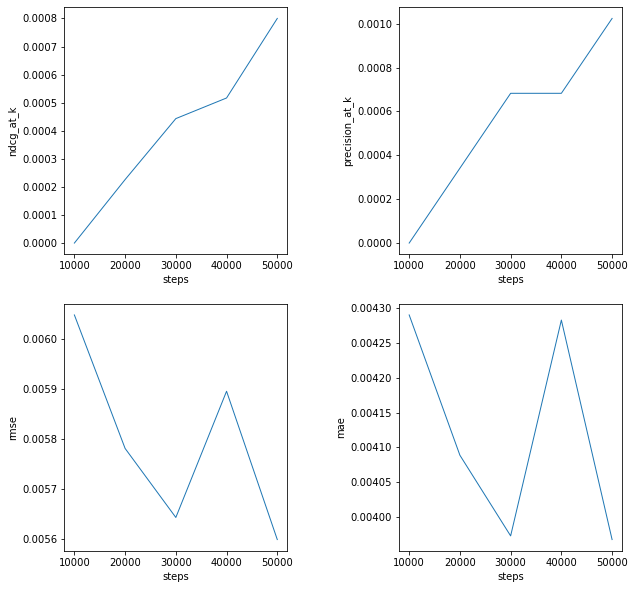

In [67]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        #sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

### 4. Test Model

#### 4.1 Item rating prediction

In [68]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        #sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsilmtt6j/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'rmse': 0.005598010239937476, 'mae': 0.003967389718474208}


In [69]:
rating_results

{'rmse': 0.005598010239937476, 'mae': 0.003967389718474208}

#### 4.2 Recommend k items
For top-k recommendation evaluation, we use the ranking pool (all the user-item pairs) we prepared at the [training step](#ranking-pool). The difference is we remove users' seen items from the pool in this step.

In [70]:
if len(RANKING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]

    ranking_results = {}
    for m in RANKING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k': TOP_K})
        #sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsilmtt6j/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'ndcg_at_k': 0.0008000222181682589, 'precision_at_k': 0.0010238907849829354}


In [71]:
ranking_results

{'ndcg_at_k': 0.0008000222181682589, 'precision_at_k': 0.0010238907849829354}

In [72]:
def course_coverage(calc_id):
    pred = prediction_df[prediction_df['calculation_id']==calc_id][:10]['course_idx'].values
    real = test[test['calculation_id']==calc_id]['course_idx'].values
    if len(real) == 0:
        return 1
    return len([c for c in pred if c in real])/len(real)

In [76]:
pred = prediction_df[prediction_df['calculation_id']=='27988.475'][:10]['course_idx'].values
real = test[test['calculation_id']=='27988.475']['course_idx'].values
print(pred)
print(real)

[ 350 1092 1312  629 1251 1287  320 1015  658  656]
[ 560    7   73 1256  517  288   53  311 1949  170 1483 1329 1219   99
   21  333  797   28  227  164  370 1100  229   23   53  141   53  290
   12   29 1805  256]


In [73]:
#accu_list = [course_coverage(calc_id) for calc_id in user_dic]
#sum(accu_list)/len(accu_list)

accu_list = []
for calc_id in user_dic:
    accu = course_coverage(calc_id)
    accu_list.append(accu)
    print(accu)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 